In [11]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import proplot as pplt
from scipy.fftpack import * 

## 读入数据

2022.01.08

- 因为xarray会将读入nc文件含有units = days 的数据识别为日期，decode_times 需要关闭，从而读入dtype为float64的 天数，而非一个时间dtype

In [12]:
ds_in = {}
for mod_name in ['obs','vr', 'rcm']:
    ds_in[mod_name] = {}
    ds_in[mod_name]['am'] = xr.open_dataset("/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA_large/t2m/extreme/extreme_"+mod_name+"_4-5.nc", decode_times = False)
    ds_in[mod_name]['jja'] = xr.open_dataset("/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA_large/t2m/extreme/extreme_"+mod_name+"_6-8.nc", decode_times = False)

vars_names = list(ds_in[mod_name]['am'].variables)[3:]
vars_names

['daily_temperature_range',
 'daily_temperature_range_variability',
 'heat_wave_total_length',
 'heat_wave_max_length']

## 计算平均

In [13]:
ds_mean = {}
for mod_name in ['obs','vr','rcm']:
    ds_mean[mod_name] = {}
    for season in ['am','jja']:
        ds_mean[mod_name][season] = ds_in[mod_name][season].mean(dim = 'time')

lon = ds_mean['obs']['am']['daily_temperature_range'].lon.values
lat = ds_mean['obs']['am']['daily_temperature_range'].lat.values

## 绘图部分
2022.01.09

为了方便绘图，更换了版本，用来传入控制左边标题的参数 proplot 0.6.4-py_0 --> 0.9.5-pyhd8ed1ab_1

### 绘图准备部分
包含写为函数的地图的绘制，以等距的spacing norm

In [14]:
## 地图绘制预备数据
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import cmaps as cmaps

In [15]:
def border_plot(axs):
    """
    进行行政区划的绘制，通过shapefilereader绘制存档的shp文件，需要传入axs，并逐个绘制
    比较消耗时间，调整完毕后最后添加边界的绘制
    """
    ##---- 直接绘图，从边界文件添加
    # for ax_ind in axs:
    # for line in borders:
    #     axs.plot(line[0::100], line[1::100], lw = 0.5, color='gray',transform=ccrs.Geodetic())
    #     axs.plot(line[0::10], line[1::10], lw = 0.4, color='black',transform=ccrs.Geodetic())
    ##---- 使用shp文件添加
        # shapefile数据下载的位置：
    # http://gaohr.win/site/blogs/2017/2017-04-18-GIS-basic-data-of-China.html
    world_border_shapefile = "/m2data2/yycheng/data_stage/CN-border/World/country.shp"
    river_border_shapefile =  "/raid52/yycheng/MPAS/REFERENCE/MODEL_CONSTANT/R1/" + "hyd1_4l.shp"
    southsea_shapefile     = "/m2data2/yycheng/data_stage/CN-border/SouthSea/" + "southsea_island.shp"
    ninelines_shapefile     = "/m2data2/yycheng/data_stage/CN-border/SouthSea/" + "nine_lines.shp"
    ## 来源： 沛沛的诸省 + 诸岛
    bou24p_shapefile     = "/m2data2/yycheng/data_stage/CN-border/peipeihelp/" + "bou2_4p.shp"
    ## 来源： https://www.resdc.cn/data.aspx?DATAID=200
    province_shapefile     = "/m2data2/yycheng/data_stage/CN-border/CN-sheng/" + "change_proj_CN-sheng-A.shp"

    for ax in axs:
        # world     = shpreader.Reader(world_border_shapefile).geometries()
        # river     = shpreader.Reader(river_border_shapefile).geometries()
        river     = shpreader.Reader(river_border_shapefile, encoding = "gbk")
        # bou24p    = shpreader.Reader(bou24p_shapefile).geometries()
        ninelines = shpreader.Reader(ninelines_shapefile).geometries()
        province  = shpreader.Reader(province_shapefile).geometries()
        # ax.add_geometries(river, ccrs.PlateCarree(), facecolor='none', edgecolor='b', linewidth=0.4, zorder=1)
        # ax.add_geometries(world, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.4, zorder=1)
        # ax.add_geometries(bou24p, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.6, zorder=1) # 沛沛map
        ax.add_geometries(province, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.6, zorder=1) # 地资所
        ax.add_geometries(ninelines, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.6, zorder=1)
        # 绘制部分的shapefile
        for region in river.records():
            if (region.attributes['NAME'] in ['黄河','长江']):
                # print("----- draw river! -----")
                # 此处需要使用 [] 让region.geometry可以迭代
                ax.add_geometries([region.geometry], ccrs.PlateCarree(), facecolor='none', edgecolor='b', linewidth=0.4, zorder=1)


### 绘图测试部分
因为子图过多，此处测试色板 norm ticks等要素

In [16]:
vars_names

['daily_temperature_range',
 'daily_temperature_range_variability',
 'heat_wave_total_length',
 'heat_wave_max_length']

/m2data2/yycheng/anaconda3/envs/proplot0528/lib/python3.8/site-packages/proplot/internals/process.py:84: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  np.issubdtype(array.dtype, np.str)
/m2data2/yycheng/anaconda3/envs/proplot0528/lib/python3.8/site-packages/proplot/internals/process.py:85: FutureWarning: Conversion of the second argument of issubdtype from `object` to `np.generic` is deprecated. In future, it will be treated as `np.object_ == np.dtype(object).type`.
  or np.issubdtype(array.dtype, np.object)


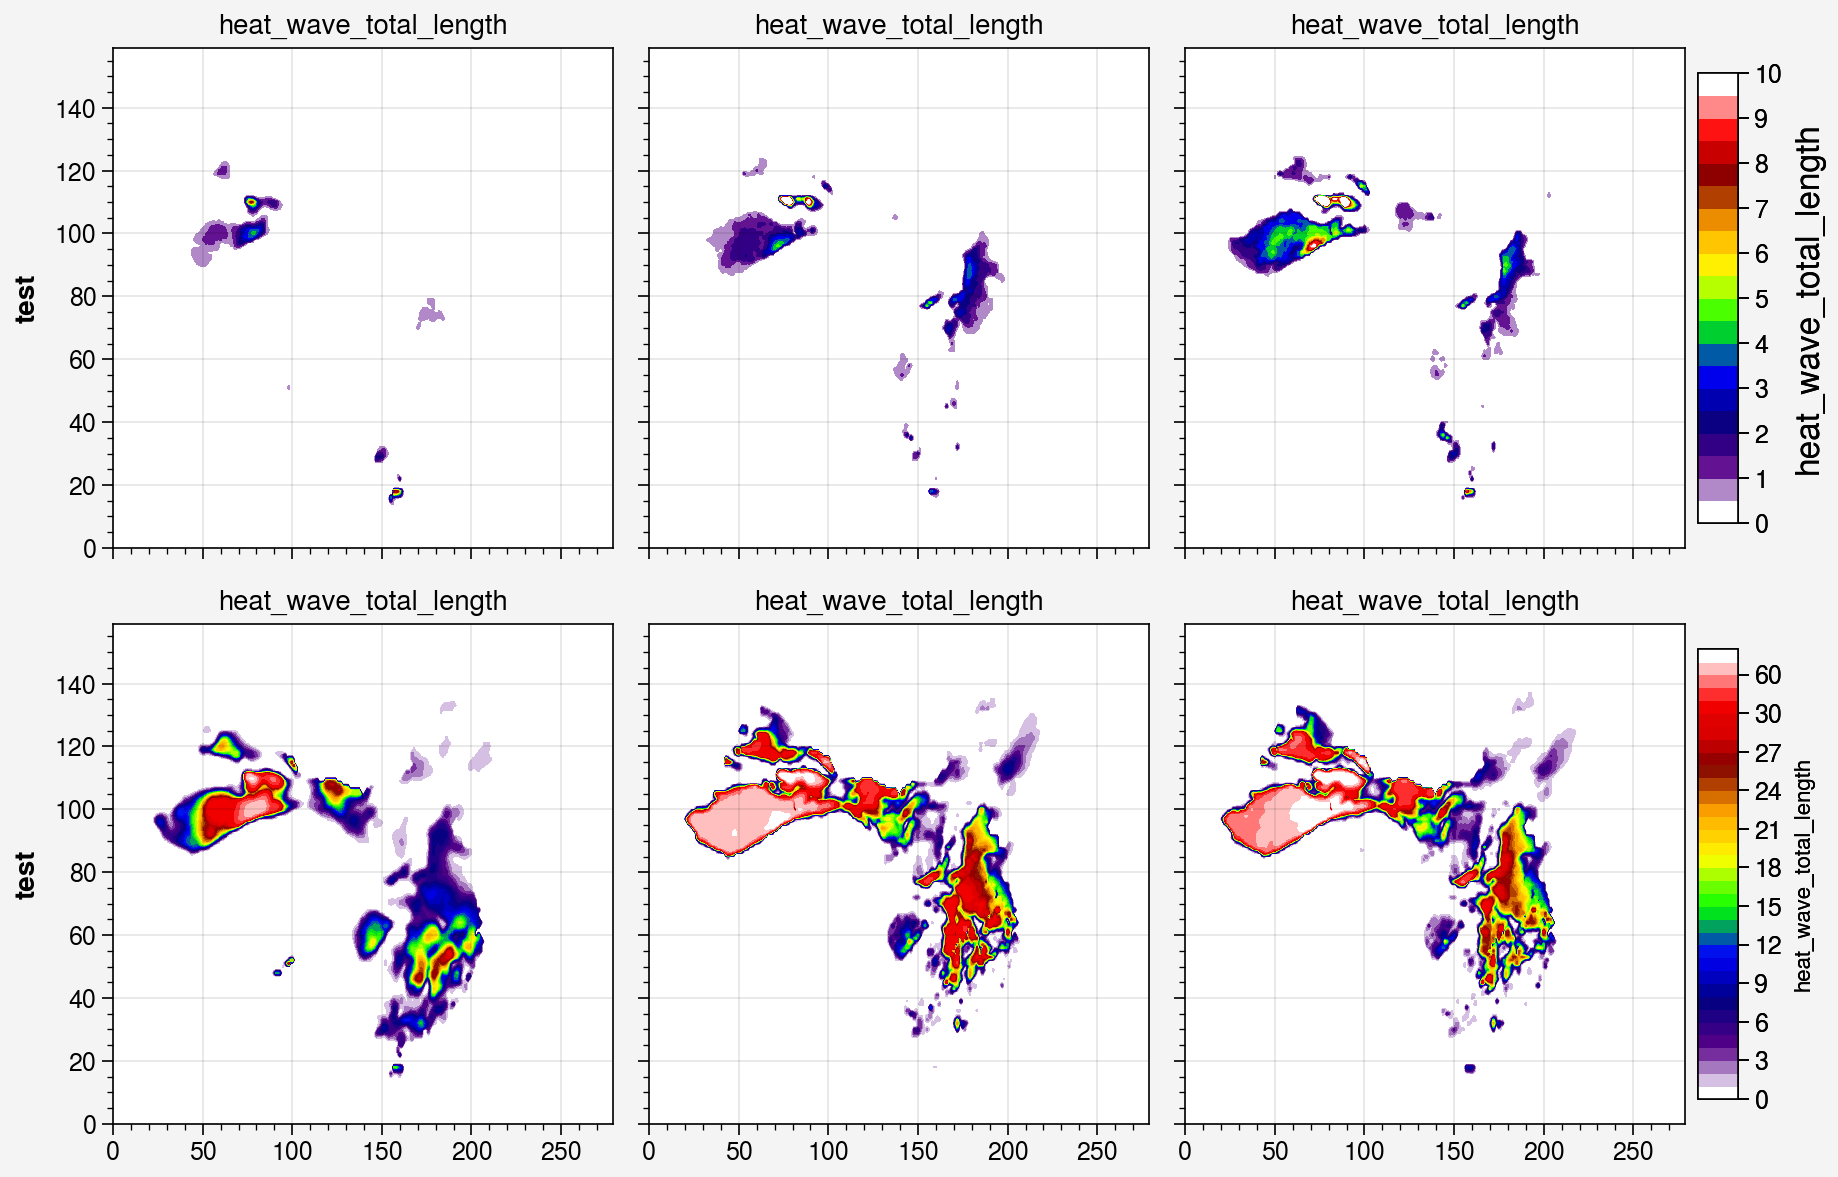

In [62]:
# ticks_am = np.linspace(5, 20, int(15 / 0.5 + 1)) # daily_temperature_range
# ticks_jja = np.linspace(5, 20, int(15 / 0.5 + 1)) # daily_temperature_range

ticks_jja = np.linspace(1,5,17) # daily_temperature_range_variability
ticks_am = np.linspace(1,5,17) # daily_temperature_range_variability

ticks_am = np.linspace(0, 10, 21) # heat_wave_total_length
ticks_jja = np.concatenate( (np.linspace(0, 30, 31),[40,50,60,70,80]), axis = 0) # heat_wave_total_length

# ticks_am = np.linspace(0,10,21) # heat_wave_max_length
# ticks_jja = np.concatenate( (np.linspace(0, 20, 21),[25,30,35,40]), axis = 0) # heat_wave_max_length

# cmap = cmaps.BkBlAqGrYeOrReViWh200  # daily_temperature_range
# cmap = cmaps.WhViBlGrYeOrReWh # heat_wave_frequency
cmap = cmaps.WhViBlGrYeOrReWh # heat_wave_total_length
# cmap = cmaps.WhViBlGrYeOrReWh  # hot_spell_max_length

fig, axs = pplt.subplots(nrows = 2,ncols = 3)
var = 'heat_wave_total_length'

mcontourf_am = axs[0].contourf(ds_mean['obs']['am'][var].values, cmap = cmap, levels = ticks_am, norm = 'segmented')
mcontourf_am = axs[1].contourf(ds_mean['vr']['am'][var].values, cmap = cmap, levels = ticks_am, norm = 'segmented')
mcontourf_am = axs[2].contourf(ds_mean['rcm']['am'][var].values, cmap = cmap, levels = ticks_am, norm = 'segmented')

mcontourf_jja = axs[3].contourf(ds_mean['obs']['jja'][var].values, cmap = cmap, levels = ticks_jja, norm = 'segmented')
mcontourf_jja = axs[4].contourf(ds_mean['vr']['jja'][var].values, cmap = cmap, levels = ticks_jja, norm = 'segmented')
mcontourf_jja = axs[5].contourf(ds_mean['rcm']['jja'][var].values, cmap = cmap, levels = ticks_jja, norm = 'segmented')

axs.format(title = var,
leftlabels=(('test'),('test')),
leftlabelsize = 10,)

axs[2].colorbar(mcontourf_am, ticks = ticks_am, norm = 'segmented', length = 0.9, title=var, labelsize = 12)
axs[5].colorbar(mcontourf_jja, ticks = ticks_jja, norm = 'segmented', length = 0.9, title=var, labelsize = 8)

### 完整绘图部分

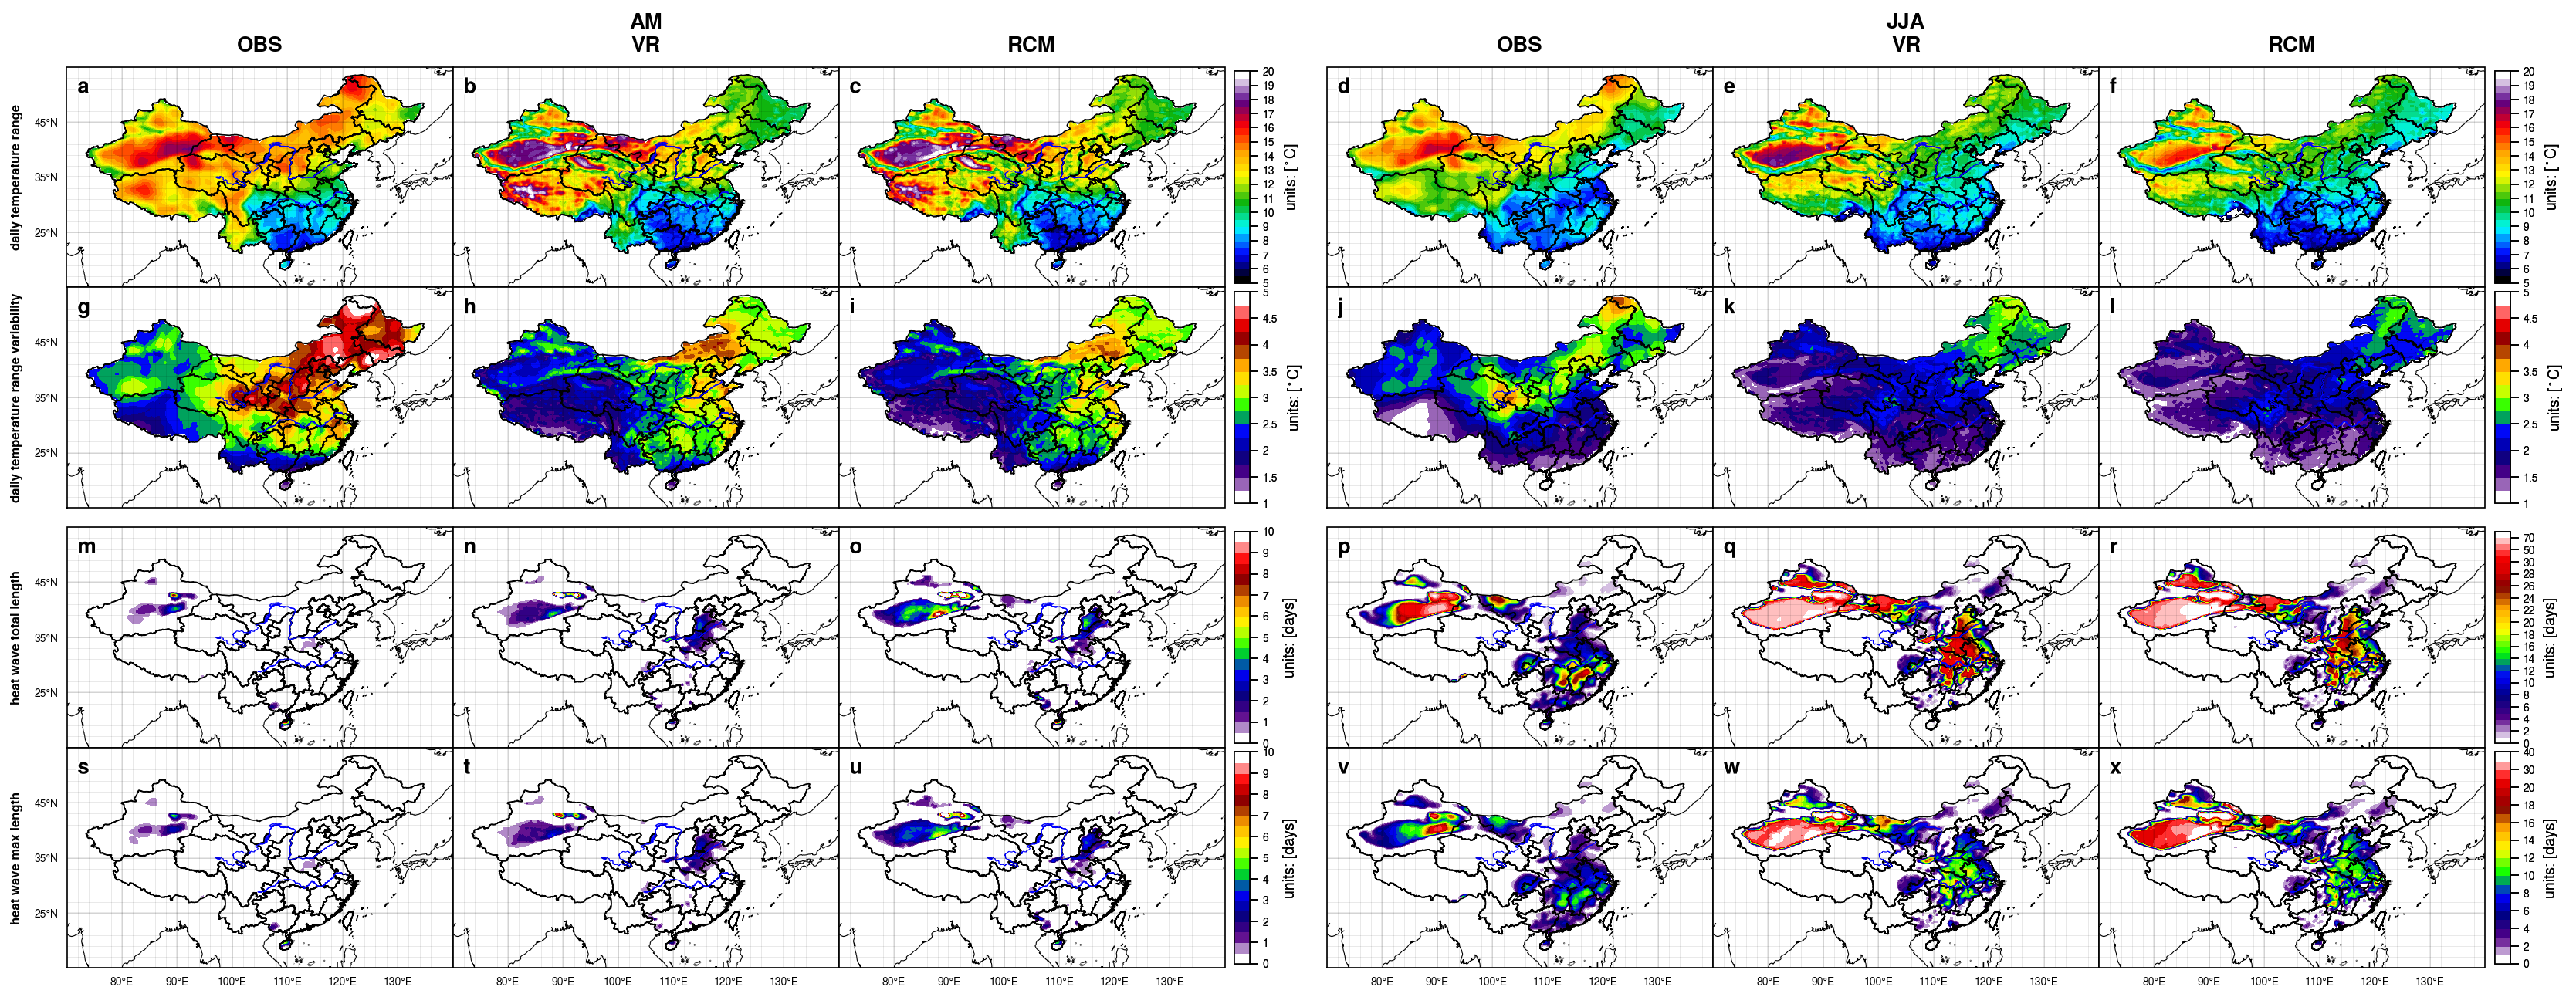

In [63]:
# import proplot as plot
from matplotlib import pyplot as plt
import proplot as plot
import collections
# ----- get filter vars coords-----

#----- create plot -----
fig, axs = plot.subplots(ncols=6 ,nrows=4, proj=('cyl'), share = True, wspace=(0, 0, 4, 0, 0), hspace=(0, 1, 0))
m_contour_list = [] # 用于保存contour设置，后续设置colorbar使用

#----- 添加海洋以及行政区划 -----
border_plot(axs)
    
def nested_dict():
    return collections.defaultdict(nested_dict)
mcontourf_dict = nested_dict()
#----- colorbar ticks 统一设置 -----
cmap_dict = {}

cmap_dict['daily_temperature_range'] = cmaps.BkBlAqGrYeOrReViWh200
cmap_dict['daily_temperature_range_variability'] = cmaps.WhViBlGrYeOrReWh
cmap_dict['heat_wave_total_length'] = cmaps.WhViBlGrYeOrReWh
cmap_dict['heat_wave_max_length'] = cmaps.WhViBlGrYeOrReWh

ticks_dict = nested_dict()

ticks_dict['am']['daily_temperature_range']  = np.linspace(5, 20, int(15 / 0.5 + 1))
ticks_dict['jja']['daily_temperature_range'] = np.linspace(5, 20, int(15 / 0.5 + 1))
ticks_dict['am']['daily_temperature_range_variability']      = np.linspace(1,5,17) # daily_temperature_range_variability 
ticks_dict['jja']['daily_temperature_range_variability']     = np.linspace(1,5,17) # daily_temperature_range_variability
ticks_dict['am']['heat_wave_total_length']   = np.linspace(0, 10, 21) # heat_wave_total_length
ticks_dict['jja']['heat_wave_total_length']  =np.concatenate( (np.linspace(0, 30, 31),[40,50,60,70,80]), axis = 0) # heat_wave_total_length
ticks_dict['am']['heat_wave_max_length']     = np.linspace(0,10,21) # heat_wave_max_length
ticks_dict['jja']['heat_wave_max_length']    =  np.concatenate( (np.linspace(0, 20, 21),[25,30,35,40]), axis = 0) # heat_wave_max_length

plot_ind = 0


for var in vars_names:    
    for season in ['am', 'jja']:
        for mod_name in ['obs','vr','rcm']:
            
            # 使用了均分的norm，处理不等距的ticks
            mcontourf_temp = axs[plot_ind].contourf(lon, lat, ds_mean[mod_name][season][var].values,\
            cmap=cmap_dict[var], levels = ticks_dict[season][var], norm = 'segmented')

            # axs[plot_ind].format(rtitle = season, title = mod_name.upper(), ltitle = var)
            mcontourf_dict[season][mod_name][var] = mcontourf_temp # 合并所有绘图obj到一个deep dict之中
            
            plot_ind = plot_ind + 1

#----- add color bar-----
color_bar_title = {}
color_bar_title['daily_temperature_range'] = 'units: ' + r"$[^\circ C$]"
color_bar_title['daily_temperature_range_variability']   = 'units: ' + r"$[^\circ C$]"
color_bar_title['heat_wave_total_length']    = 'units: ' + "[days]"
color_bar_title['heat_wave_max_length']    = 'units: ' + "[days]"

plot_ind = 0
for var in vars_names:
    axs[plot_ind, 2].colorbar(mcontourf_dict['am']['obs'][var], loc='r', width=0.1, extend = 'both',length = 0.96,\
    ticklabelsize=5,labelsize = 7, ticks=ticks_dict['am'][var][::2], title=color_bar_title[var])
    axs[plot_ind, 5].colorbar(mcontourf_dict['jja']['obs'][var], loc='r', width=0.1, extend = 'both',length = 0.96,\
    ticklabelsize=5,labelsize = 7, ticks=ticks_dict['jja'][var][::2], title=color_bar_title[var])
    plot_ind = plot_ind + 1

# ----- format setting -----
axs.format(
abc=True,
abcloc = 'ul',
#----- 地图底图设置 -----
# reso = 'x-hi',
reso = 'med',
# coast = False,
coast = True,
coastlinewidth = 0.4,
borders = False,
lakes = False,
land  = False,
ocean = False,
# cartopyautoextent = True, 
# borderslinewidth=.5,
labels = False,
longrid  = True,
latgrid  = True,
#-----GEO axis-----
lonlim=(70, 140), latlim=(15, 55),
gridlabelsize = 5,
gridminor = True,
lonlocator = np.arange(70,142,10),
latlocator = np.arange(15,55+2,10),
lonminorlocator = np.arange(70,140+2,2),
latminorlocator = np.arange(15,55+2,2),
#-----line label-----
# linewidth = 0.5,
# suptitle="3000km-2000km bandpass 500hPa height(1998-06 timemean)",
# suptitle="precipitation",
toplabels=(' \nOBS', 'AM\nVR', ' \nRCM', ' \nOBS', 'JJA\nVR', ' \nRCM'),
leftlabels=('daily temperature range','daily temperature range variability','heat wave total length','heat wave max length'),
leftlabelsize = 6.,
rc_kw = {'leftlabel.rotation':90.},
)

# 合并子图之后控制边界的labels绘制
axs[:-1,0].format(labels = True, lonlabels = False, latlabels = True)
axs[3,1:].format(labels = True, lonlabels = True, latlabels = False)
axs[-1,0].format(labels = True, lonlabels = True, latlabels = True)
#----- save figure -----
fig.patch.set_facecolor('white')
plt.savefig('./output_pic/t2m_extreme_2022.01.11.png', dpi=600, facecolor= "white")